In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import theano.tensor as tt


/Users/claus/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



### Generate sample data

We generate book rates for 52 weeks of the year, where each rate represents the % of orders booked for a given week in each time period. So, we get 52x52 values, each representing the % of final bookings for week W booked as of time period T.

In [2]:
n_weeks = 52
n_time_periods = 52

In [3]:
event_weeks = np.linspace(1, n_weeks, n_time_periods, dtype=int)
event_weeks

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52])

In [101]:
time_periods = np.linspace(n_time_periods, 1, n_time_periods, dtype=int)
time_periods

array([52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36,
       35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19,
       18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,
        1])

In [108]:
reservation_weeks = np.abs(time_periods-n_time_periods-1)

In [109]:
reservation_weeks

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52])

In [110]:
booking_rate = reservation_weeks/n_time_periods
booking_rate

array([0.01923077, 0.03846154, 0.05769231, 0.07692308, 0.09615385,
       0.11538462, 0.13461538, 0.15384615, 0.17307692, 0.19230769,
       0.21153846, 0.23076923, 0.25      , 0.26923077, 0.28846154,
       0.30769231, 0.32692308, 0.34615385, 0.36538462, 0.38461538,
       0.40384615, 0.42307692, 0.44230769, 0.46153846, 0.48076923,
       0.5       , 0.51923077, 0.53846154, 0.55769231, 0.57692308,
       0.59615385, 0.61538462, 0.63461538, 0.65384615, 0.67307692,
       0.69230769, 0.71153846, 0.73076923, 0.75      , 0.76923077,
       0.78846154, 0.80769231, 0.82692308, 0.84615385, 0.86538462,
       0.88461538, 0.90384615, 0.92307692, 0.94230769, 0.96153846,
       0.98076923, 1.        ])

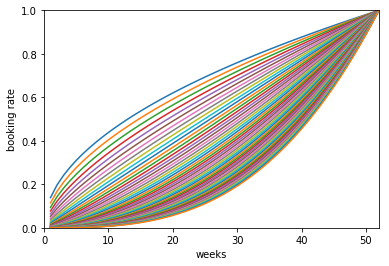

In [111]:
fig, ax = plt.subplots()
rates = np.linspace(.5, 3, n_weeks)
for r in rates:
    ax.plot(reservation_weeks, np.power(reservation_weeks/n_time_periods, r), label=f'r={r}')
ax.set(xlim=[0,n_weeks], ylim=[0,1], xlabel='weeks', ylabel='booking rate')
plt.show()

In [112]:
bookings_rates = [np.power(reservation_weeks/n_time_periods, r) for r in rates]

In [113]:
col_time_periods = [f'T{t}' for t in time_periods]
df_bookings_rates = pd.DataFrame(bookings_rates, columns=col_time_periods)

In [114]:
df_bookings_rates.loc[:, 'event_week'] = [f'W{w}' for w in event_weeks]

In [115]:
df_bookings_rates = df_bookings_rates[['event_week'] + col_time_periods]

In [116]:
df_bookings_rates.head()

,event_week,T52,T51,T50,T49,T48,T47,T46,T45,T44,...,T10,T9,T8,T7,T6,T5,T4,T3,T2,T1
0,W1,0.138675,0.196116,0.240192,0.277350,0.310087,0.339683,0.366900,0.392232,0.416025,...,0.909353,0.919866,0.930261,0.940540,0.950708,0.960769,0.970725,0.980581,0.990338,1.0
1,W2,0.114256,0.167168,0.208848,0.244581,0.276458,0.305563,0.332549,0.357845,0.381749,...,0.900921,0.912364,0.923691,0.934904,0.946008,0.957007,0.967902,0.978697,0.989396,1.0
2,W3,0.094138,0.142492,0.181593,0.215684,0.246476,0.274870,0.301415,0.326472,0.350298,...,0.892567,0.904923,0.917167,0.929302,0.941332,0.953259,0.965087,0.976817,0.988454,1.0
3,W4,0.077561,0.121459,0.157896,0.190201,0.219745,0.247260,0.273195,0.297850,0.321437,...,0.884291,0.897543,0.910690,0.923734,0.936679,0.949526,0.962279,0.974941,0.987514,1.0
4,W5,0.063904,0.103530,0.137291,0.167729,0.195914,0.222424,0.247618,0.271737,0.294954,...,0.876091,0.890223,0.904259,0.918199,0.932048,0.945808,0.959480,0.973069,0.986574,1.0


In [117]:
total_reservations = np.random.randint(3000, 10000, n_weeks)

In [118]:
total_reservations

array([9270, 6229, 8212, 5333, 4797, 9216, 5715, 5567, 9470, 9180, 6613,
       4953, 5641, 4429, 3218, 6646, 7760, 3600, 3994, 5087, 6006, 8842,
       5922, 9249, 6577, 9079, 9237, 5026, 3901, 9074, 3739, 8251, 3619,
       6511, 6670, 4861, 7299, 7528, 8935, 3001, 7443, 6237, 3424, 4152,
       8851, 5882, 3443, 3862, 7527, 5707, 3774, 6240])

In [119]:
event_weeks

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52])

In [120]:
bookings_rates

[array([0.13867505, 0.19611614, 0.24019223, 0.2773501 , 0.31008684,
        0.33968311, 0.36689969, 0.39223227, 0.41602515, 0.43852901,
        0.45993311, 0.48038446, 0.5       , 0.51887452, 0.53708616,
        0.5547002 , 0.57177187, 0.58834841, 0.60447052, 0.62017367,
        0.63548891, 0.65044364, 0.66506217, 0.67936622, 0.69337525,
        0.70710678, 0.72057669, 0.73379939, 0.74678799, 0.75955453,
        0.77211   , 0.78446454, 0.79662751, 0.80860754, 0.82041265,
        0.83205029, 0.84352739, 0.85485041, 0.8660254 , 0.87705802,
        0.88795357, 0.89871703, 0.90935311, 0.91986621, 0.93026051,
        0.94053994, 0.95070824, 0.96076892, 0.97072534, 0.98058068,
        0.99033794, 1.        ]),
 array([0.1142564 , 0.16716752, 0.20884758, 0.2445813 , 0.27645774,
        0.30556303, 0.3325492 , 0.35784473, 0.3817494 , 0.40448286,
        0.42621185, 0.44706656, 0.46715098, 0.48654978, 0.50533302,
        0.52355944, 0.5412789 , 0.55853415, 0.57536219, 0.59179528,
        0.6078

In [229]:
cumulative_reservations = [np.round(bookings_rates[i-1][:-1] * total_reservations[i-1], 0).astype(int) for i in event_weeks]
cumulative_reservations

[array([1286, 1818, 2227, 2571, 2875, 3149, 3401, 3636, 3857, 4065, 4264,
        4453, 4635, 4810, 4979, 5142, 5300, 5454, 5603, 5749, 5891, 6030,
        6165, 6298, 6428, 6555, 6680, 6802, 6923, 7041, 7157, 7272, 7385,
        7496, 7605, 7713, 7819, 7924, 8028, 8130, 8231, 8331, 8430, 8527,
        8624, 8719, 8813, 8906, 8999, 9090, 9180]),
 array([ 712, 1041, 1301, 1523, 1722, 1903, 2071, 2229, 2378, 2520, 2655,
        2785, 2910, 3031, 3148, 3261, 3372, 3479, 3584, 3686, 3786, 3884,
        3980, 4074, 4167, 4257, 4347, 4434, 4520, 4605, 4689, 4772, 4853,
        4933, 5012, 5090, 5167, 5244, 5319, 5393, 5467, 5540, 5612, 5683,
        5754, 5824, 5893, 5961, 6029, 6096, 6163]),
 array([ 773, 1170, 1491, 1771, 2024, 2257, 2475, 2681, 2877, 3064, 3243,
        3417, 3584, 3747, 3904, 4058, 4208, 4354, 4497, 4637, 4775, 4909,
        5042, 5172, 5299, 5425, 5549, 5671, 5791, 5910, 6027, 6143, 6257,
        6369, 6481, 6591, 6700, 6807, 6914, 7020, 7124, 7227, 7330, 7431,
        

In [233]:
time_periods[:-1]

array([52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36,
       35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19,
       18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2])

In [234]:
col_time_periods = [f'T{t}' for t in time_periods[:-1]]
df_cumulative_reservations = pd.DataFrame(cumulative_reservations, columns=col_time_periods)
df_cumulative_reservations.loc[:, 'event_week'] = [f'W{w}' for w in event_weeks]
df_cumulative_reservations = df_cumulative_reservations[['event_week'] + col_time_periods]
df_cumulative_reservations.head()

,event_week,T52,T51,T50,T49,T48,T47,T46,T45,T44,...,T11,T10,T9,T8,T7,T6,T5,T4,T3,T2
0,W1,1286,1818,2227,2571,2875,3149,3401,3636,3857,...,8331,8430,8527,8624,8719,8813,8906,8999,9090,9180
1,W2,712,1041,1301,1523,1722,1903,2071,2229,2378,...,5540,5612,5683,5754,5824,5893,5961,6029,6096,6163
2,W3,773,1170,1491,1771,2024,2257,2475,2681,2877,...,7227,7330,7431,7532,7631,7730,7828,7925,8022,8117
3,W4,414,648,842,1014,1172,1319,1457,1588,1714,...,4645,4716,4787,4857,4926,4995,5064,5132,5199,5266
4,W5,307,497,659,805,940,1067,1188,1304,1415,...,4134,4203,4270,4338,4405,4471,4537,4603,4668,4733


## Model

In [124]:
cumulative_reservations[0][1:] / bookings_rates[0][1:]

array([9270.01747571, 9271.74036162, 9269.87232922, 9271.59641054,
       9270.40498936, 9269.5634972 , 9270.01747571, 9271.07417964,
       9269.62620606, 9270.91341974, 9269.65869562, 9270.        ,
       9270.06395416, 9270.39349039, 9269.87232922, 9269.43110127,
       9270.01747571, 9269.26917008, 9269.98395899, 9270.02802687,
       9270.59574432, 9269.81004449, 9270.40498936, 9270.59343947,
       9270.16990136, 9270.35258429, 9269.5634972 , 9270.368642  ,
       9269.90724873, 9269.40466474, 9270.01747571, 9270.33015659,
       9270.25736047, 9269.72537735, 9269.87232922, 9269.40852365,
       9269.45798677, 9269.93592211, 9269.62620606, 9269.62883989,
       9269.88104408, 9270.32625301, 9269.82630513, 9270.52144284,
       9270.2070377 , 9269.93124444, 9269.65869562, 9270.38740797,
       9270.01747571, 9269.5630965 , 9270.        ])

In [236]:
total_reservations

array([9270, 6229, 8212, 5333, 4797, 9216, 5715, 5567, 9470, 9180, 6613,
       4953, 5641, 4429, 3218, 6646, 7760, 3600, 3994, 5087, 6006, 8842,
       5922, 9249, 6577, 9079, 9237, 5026, 3901, 9074, 3739, 8251, 3619,
       6511, 6670, 4861, 7299, 7528, 8935, 3001, 7443, 6237, 3424, 4152,
       8851, 5882, 3443, 3862, 7527, 5707, 3774, 6240])

In [260]:
total_reservations_tiled = np.tile(total_reservations,(n_weeks-1,1)).T

In [253]:
n_weeks

52

In [254]:
cumulative_reservations[1][:-1]

array([ 712, 1041, 1301, 1523, 1722, 1903, 2071, 2229, 2378, 2520, 2655,
       2785, 2910, 3031, 3148, 3261, 3372, 3479, 3584, 3686, 3786, 3884,
       3980, 4074, 4167, 4257, 4347, 4434, 4520, 4605, 4689, 4772, 4853,
       4933, 5012, 5090, 5167, 5244, 5319, 5393, 5467, 5540, 5612, 5683,
       5754, 5824, 5893, 5961, 6029, 6096])

In [261]:
# cumulative_reservations[1] / bookings_rates[1]

In [317]:
cumulative_reservations[12][-12:]

array([4240, 4355, 4471, 4587, 4703, 4820, 4936, 5053, 5170, 5288, 5405,
       5523])

In [362]:
start_week = 0
end_week = 2
# weeks_model = slice(start_week, end_week)
event_weeks[start_week:end_week]

array([1, 2])

In [363]:
np.array(cumulative_reservations)[start_week:end_week][:, -12:]

array([[8130, 8231, 8331, 8430, 8527, 8624, 8719, 8813, 8906, 8999, 9090,
        9180],
       [5393, 5467, 5540, 5612, 5683, 5754, 5824, 5893, 5961, 6029, 6096,
        6163]])

In [379]:
np.array(cumulative_reservations)[start_week:end_week][:, -n_time_periods_model:]

array([[8527, 8624, 8719, 8813, 8906, 8999, 9090, 9180],
       [5683, 5754, 5824, 5893, 5961, 6029, 6096, 6163]])

In [394]:
with pm.Model() as model:
    
    start_week = 26
    end_week = 29
    weeks_model = event_weeks[start_week:end_week]
    n_weeks_model = len(weeks_model)
    n_time_periods_model = 8
    
    mu = pm.HalfCauchy('mu', 0.5, shape=n_time_periods_model)
    sd = pm.HalfCauchy('sd', 1, shape=n_time_periods_model)
    
    booking_rate = pm.Gamma('booking_rate', mu=mu, sd=sd, shape=(n_weeks_model, n_time_periods_model)) #alpha=1, beta=1, shape=(3, n_weeks))

    e = pm.Deterministic('forecasted_reservations', np.array(cumulative_reservations)[start_week:end_week][:, -n_time_periods_model:] / booking_rate)
    
    a = pm.Poisson('final_reservations', mu=e, observed=np.array(total_reservations_tiled)[start_week:end_week][:, -n_time_periods_model:])
    

In [395]:
model

In [396]:
booking_rate.tag.test_value.shape

(3, 8)

In [397]:
n_samples = 10000
n_chains = 1
seed = 42
SAMPLE_KWARGS = {
    'draws': n_samples,
    'tune': int(n_samples/2),
    'chains': n_chains,
    'cores': n_chains,
    'random_seed': [seed + i for i in range(n_chains)] if n_chains > 1 else seed,
    'nuts_kwargs': {'target_accept': 0.9}
}

In [398]:
with model:
    trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/claus/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Sequential sampling (1 chains in 1 job)
NUTS: [booking_rate_log__, sd_log__, mu_log__]
100%|██████████| 15000/15000 [06:52<00:00, 36.34it/s]
There were 759 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


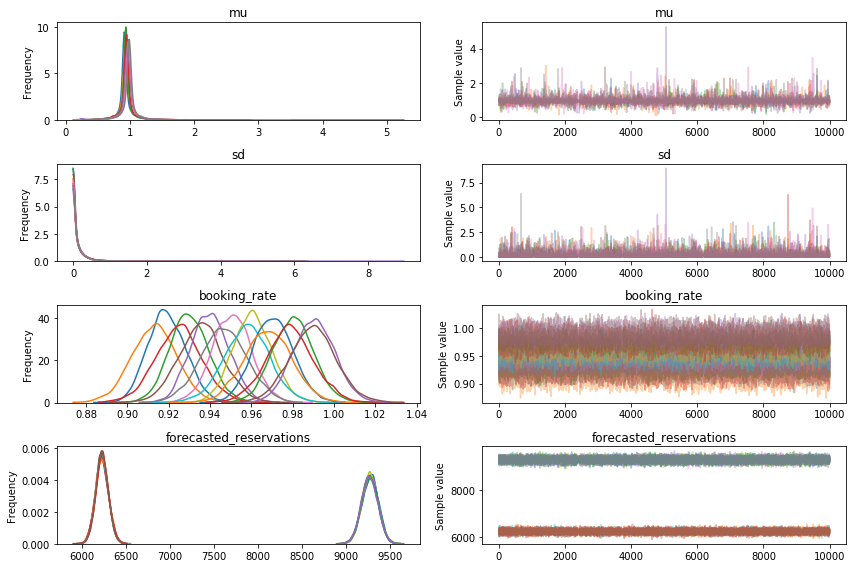

In [369]:
pm.traceplot(trace);

In [384]:
np.mean(trace['booking_rate'], axis=0)[0]

array([0.91906438, 0.92986878, 0.94007821, 0.95047735, 0.96048093,
       0.9706028 , 0.9803131 , 0.99031639])

In [388]:
np.array(bookings_rates)[start_week:end_week, -n_time_periods_model-1:-1]

array([[0.91986621, 0.93026051, 0.94053994, 0.95070824, 0.96076892,
        0.97072534, 0.98058068, 0.99033794],
       [0.91236425, 0.92369077, 0.93490433, 0.94600848, 0.95700658,
        0.96790182, 0.97869724, 0.98939572]])

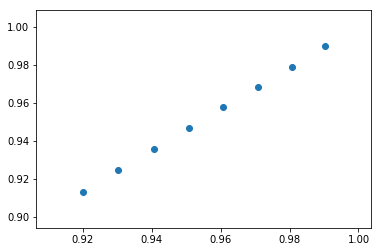

In [390]:
plt.scatter(np.array(bookings_rates)[start_week, -n_time_periods_model-1:-1], 
            np.mean(trace['booking_rate'], axis=0)[1]);

In [391]:
np.percentile(trace['booking_rate'], q=[5, 50, 95], axis=0)

array([[[0.90462593, 0.91488174, 0.92519131, 0.93525621, 0.94535446,
         0.95493625, 0.96442309, 0.97406279],
        [0.89529398, 0.90621256, 0.91794801, 0.92788863, 0.93943274,
         0.94908697, 0.95983852, 0.97138185]],

       [[0.91869443, 0.92961358, 0.93997061, 0.95044596, 0.96036675,
         0.97049444, 0.98027214, 0.99036009],
        [0.91327258, 0.92478564, 0.93583306, 0.94654998, 0.95780975,
         0.96816977, 0.97858041, 0.98977511]],

       [[0.93426625, 0.94549036, 0.9555025 , 0.96607451, 0.97610191,
         0.98676637, 0.99646849, 1.00667684],
        [0.93081797, 0.94326859, 0.95379963, 0.96533311, 0.97575723,
         0.98692523, 0.99834856, 1.00821965]]])

In [392]:
with model:
    ppc = pm.sample_ppc(trace)

100%|██████████| 10000/10000 [00:02<00:00, 3802.05it/s]


In [393]:
np.mean(ppc['final_reservations'], axis=0)

array([[9279.2801, 9276.2654, 9275.6471, 9273.1107, 9273.7551, 9269.5761,
        9271.5892, 9274.106 ],
       [6222.0362, 6224.5101, 6225.1355, 6226.8547, 6226.069 , 6229.4236,
        6230.3721, 6228.7091]])